# Creating the dataset in another format

In [1]:
import numpy as np
import uproot as ur
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd
import copy
import sys

from scipy import stats
from numba import njit

In [2]:
sys.path.append('../')

from src import load_data

## Loading root file and preprocessing the data

- We load the root file using uproot and show its contents. We can then obtain a dictionary where keys are some of the names shown above and values are numpy arrays containing the data. **Note that we only keep a subset of the information**.

In [3]:
data_dict = load_data.load_data_as_dict(TTree_features_dict={
                        "t_hk_obox":
                                ["saa", 
                               "raz",
                               "decz",
                               "rax",
                               "decx",
                               "obox_mode",
                               "fe_temp",
                               "glon", 
                               "glat",
                               "tunix",
                               "fe_cosmic",
                               "fe_rate"],
                        "B_field":
                                ["B_r",
                                 "B_theta",
                                 "B_phi"]
                        })

TTree: t_hk_obox's contents:
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
odd_index            | int32_t                  | AsDtype('>i4')
even_index           | int32_t                  | AsDtype('>i4')
odd_is_bad           | int32_t                  | AsDtype('>i4')
even_is_bad          | int32_t                  | AsDtype('>i4')
obox_is_bad          | int32_t                  | AsDtype('>i4')
packet_num           | uint16_t                 | AsDtype('>u2')
timestamp            | uint32_t                 | AsDtype('>u4')
obox_mode            | uint8_t                  | AsDtype('uint8')
cpu_status           | uint16_t                 | AsDtype('>u2')
trig_status          | uint8_t                  | AsDtype('uint8')
comm_status          | uint8_t                  | AsDtype('uint8')
ct_temp              | float                    | AsDtype('>f4')
chain_temp           | 

The TTree `B_field` contains information on the magnetic field and is aligned with the data in `t_hk_obox`

In [4]:
data_dict.keys()

dict_keys(['saa', 'raz', 'decz', 'rax', 'decx', 'obox_mode', 'fe_temp', 'glon', 'glat', 'tunix', 'fe_cosmic', 'fe_rate', 'B_r', 'B_theta', 'B_phi'])

- Create a pandas dataframe containing all the features we selected where `fe_temp`, `fe_cosmic` and `fe_rate` are summed up over the modules (sum of $25$ modules).

In [5]:
def try_sum_axis_1(el):
    try:
        return np.sum(el, axis=1)
    except:
        return el
    
data_np = np.array([try_sum_axis_1(el) for key, el in data_dict.items()])

In [6]:
column_names = ["sum_"*(k in ["fe_cosmic", "fe_temp", "fe_rate"])+k for k in data_dict.keys()]
data_df = pd.DataFrame(data_np.T, columns=column_names)
data_df

,saa,raz,decz,rax,decx,obox_mode,sum_fe_temp,glon,glat,tunix,sum_fe_cosmic,sum_fe_rate,B_r,B_theta,B_phi
0,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.248994,-18.145817,1.473950e+09,0.0,0.0,22978.488024,-27875.425937,6282.740022
1,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.148294,-18.231030,1.473950e+09,0.0,0.0,23045.553463,-27845.821903,6289.577967
2,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.047467,-18.316198,1.473950e+09,0.0,0.0,23112.394223,-27816.130122,6296.418849
3,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-175.845556,-18.486292,1.473950e+09,0.0,0.0,23245.311806,-27756.526414,6310.101138
4,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-175.744447,-18.571237,1.473950e+09,0.0,0.0,23311.402886,-27726.609781,6316.944439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6210970,2.0,268.013883,-31.620136,275.484638,58.161383,4.0,0.0,171.225550,-42.585450,1.502787e+09,0.0,0.0,44109.780558,-16055.052240,6686.401683
6210971,2.0,268.163352,-31.627999,275.427072,58.165486,4.0,0.0,171.392950,-42.595320,1.502787e+09,0.0,0.0,44078.264948,-16059.079066,6700.485328
6210972,2.0,268.312347,-31.635979,275.369218,58.169123,4.0,0.0,171.560500,-42.604890,1.502787e+09,0.0,0.0,44046.393963,-16063.233767,6714.466567
6210973,2.0,268.461162,-31.644019,275.311241,58.172357,4.0,0.0,171.728050,-42.614190,1.502787e+09,0.0,0.0,44014.515542,-16067.598163,6728.385629


**Need for normalizing some features ? Probably, we'll do it later and after splitting the data (otherwise data leakage)!!**

- Filter out the data and bin the data

We first remove a huge part of missing data

In [7]:
last_non_zero = data_df.shape[0]-(np.flip(data_df["sum_fe_rate"])>0).argmax() - 1

In [8]:
data_df = data_df.iloc[:last_non_zero+1, :]
data_df

,saa,raz,decz,rax,decx,obox_mode,sum_fe_temp,glon,glat,tunix,sum_fe_cosmic,sum_fe_rate,B_r,B_theta,B_phi
0,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.248994,-18.145817,1.473950e+09,0.0,0.0,22978.488024,-27875.425937,6282.740022
1,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.148294,-18.231030,1.473950e+09,0.0,0.0,23045.553463,-27845.821903,6289.577967
2,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.047467,-18.316198,1.473950e+09,0.0,0.0,23112.394223,-27816.130122,6296.418849
3,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-175.845556,-18.486292,1.473950e+09,0.0,0.0,23245.311806,-27756.526414,6310.101138
4,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-175.744447,-18.571237,1.473950e+09,0.0,0.0,23311.402886,-27726.609781,6316.944439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6187662,0.0,274.174833,-4.945285,260.499167,84.911170,4.0,0.0,43.835300,-15.995880,1.491273e+09,0.0,0.0,20797.564440,-18662.786449,-3486.045002
6187663,0.0,274.276958,-5.029454,260.767636,84.828197,4.0,0.0,43.930200,-16.080150,1.491273e+09,0.0,0.0,20848.026922,-18635.681413,-3515.989772
6187664,0.0,274.379394,-5.113467,261.032234,84.745364,4.0,0.0,44.025250,-16.164390,1.491273e+09,0.0,0.0,20898.528499,-18608.662998,-3545.976294
6187665,0.0,274.481898,-5.197639,261.290657,84.662301,4.0,0.0,44.120350,-16.248570,1.491273e+09,0.0,0.0,20949.138349,-18581.787518,-3575.998276


Then we "bin" the data (like profile hist but without error bars and without plotting)

In [9]:
tunix_min = data_df["tunix"].min()
tunix_shifted = data_df["tunix"] - tunix_min
bins = np.arange(0, tunix_shifted.max()+2, 2)

# Obtain indices of the bins in which the data falls.
# It will take the bin on the right, not the one of the left
indices_digitized = np.digitize(tunix_shifted, bins)

# Quantized Shifted Time
t = bins[indices_digitized]

In [10]:
data_df.loc[:, ("idx")] = indices_digitized

/tmp/ipykernel_3826/3418129158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.loc[:, ("idx")] = indices_digitized


In [11]:
data_df

,saa,raz,decz,rax,decx,obox_mode,sum_fe_temp,glon,glat,tunix,sum_fe_cosmic,sum_fe_rate,B_r,B_theta,B_phi,idx
0,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.248994,-18.145817,1.473950e+09,0.0,0.0,22978.488024,-27875.425937,6282.740022,1
1,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.148294,-18.231030,1.473950e+09,0.0,0.0,23045.553463,-27845.821903,6289.577967,2
2,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.047467,-18.316198,1.473950e+09,0.0,0.0,23112.394223,-27816.130122,6296.418849,3
3,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-175.845556,-18.486292,1.473950e+09,0.0,0.0,23245.311806,-27756.526414,6310.101138,5
4,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-175.744447,-18.571237,1.473950e+09,0.0,0.0,23311.402886,-27726.609781,6316.944439,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6187662,0.0,274.174833,-4.945285,260.499167,84.911170,4.0,0.0,43.835300,-15.995880,1.491273e+09,0.0,0.0,20797.564440,-18662.786449,-3486.045002,8661514
6187663,0.0,274.276958,-5.029454,260.767636,84.828197,4.0,0.0,43.930200,-16.080150,1.491273e+09,0.0,0.0,20848.026922,-18635.681413,-3515.989772,8661515
6187664,0.0,274.379394,-5.113467,261.032234,84.745364,4.0,0.0,44.025250,-16.164390,1.491273e+09,0.0,0.0,20898.528499,-18608.662998,-3545.976294,8661516
6187665,0.0,274.481898,-5.197639,261.290657,84.662301,4.0,0.0,44.120350,-16.248570,1.491273e+09,0.0,0.0,20949.138349,-18581.787518,-3575.998276,8661517


In [12]:
data_df = data_df.groupby("idx").mean()

In [13]:
data_df

,saa,raz,decz,rax,decx,obox_mode,sum_fe_temp,glon,glat,tunix,sum_fe_cosmic,sum_fe_rate,B_r,B_theta,B_phi
idx,,,,,,,,,,,,,,,
1,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.248994,-18.145817,1.473950e+09,0.0,0.0,22978.488024,-27875.425937,6282.740022
2,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.148294,-18.231030,1.473950e+09,0.0,0.0,23045.553463,-27845.821903,6289.577967
3,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.047467,-18.316198,1.473950e+09,0.0,0.0,23112.394223,-27816.130122,6296.418849
5,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-175.845556,-18.486292,1.473950e+09,0.0,0.0,23245.311806,-27756.526414,6310.101138
6,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-175.744447,-18.571237,1.473950e+09,0.0,0.0,23311.402886,-27726.609781,6316.944439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8661514,0.0,274.174833,-4.945285,260.499167,84.911170,4.0,0.0,43.835300,-15.995880,1.491273e+09,0.0,0.0,20797.564440,-18662.786449,-3486.045002
8661515,0.0,274.276958,-5.029454,260.767636,84.828197,4.0,0.0,43.930200,-16.080150,1.491273e+09,0.0,0.0,20848.026922,-18635.681413,-3515.989772
8661516,0.0,274.379394,-5.113467,261.032234,84.745364,4.0,0.0,44.025250,-16.164390,1.491273e+09,0.0,0.0,20898.528499,-18608.662998,-3545.976294


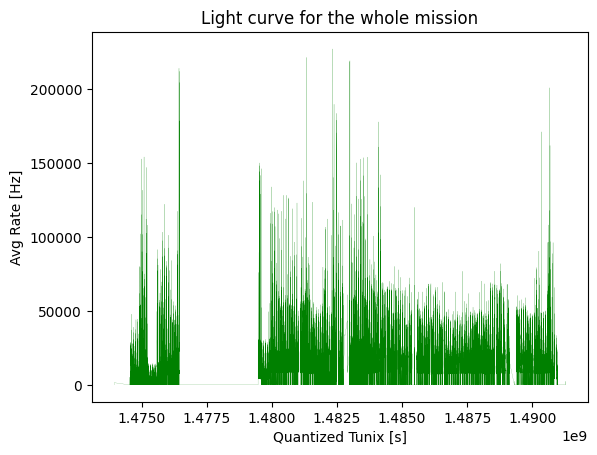

In [14]:
plt.plot(data_df['tunix'], data_df['sum_fe_rate'], 'g', linewidth=0.1)
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve for the whole mission")
plt.show()

- We need to filter even more by removing the huge middle part with missing data when the astronauts went onboard the space station.

924603 1430.0 924648 5.0


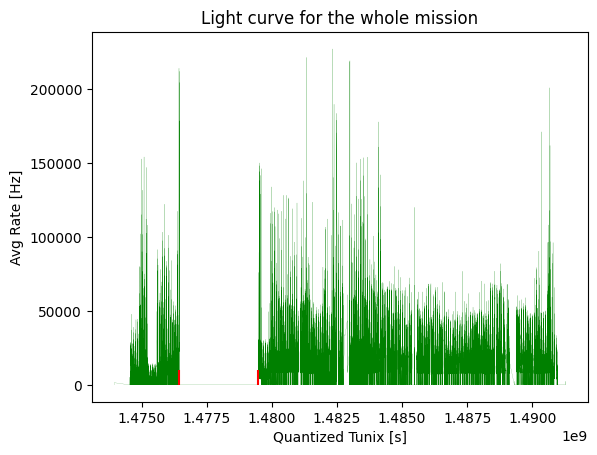

In [15]:
# Find range
idx_left = data_df.shape[0] - np.argmax((np.flip(data_df['tunix']) < 1.4775*1e9)\
                     & (np.flip(data_df['sum_fe_rate']) > 0)) - 1
idx_right = np.argmax((data_df['tunix'] > 1.4775*1e9) & (data_df['sum_fe_rate'] > 0))
print(idx_left, data_df['sum_fe_rate'].iloc[idx_left], idx_right, data_df['sum_fe_rate'].iloc[idx_right])

# Let's visualize to see if correct idx
plt.plot(data_df['tunix'], data_df['sum_fe_rate'], 'g', linewidth=0.1)
plt.vlines(data_df['tunix'].iloc[idx_left], 0, 10_000, 'r')
plt.vlines(data_df['tunix'].iloc[idx_right], 0, 10_000, 'r')
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve for the whole mission")
plt.show()

It also showed that there are data that we're not interested in within this period. Let's delete them from our dataframe, it shouldn't impact the light curve.

In [16]:
data_df = data_df.iloc[np.concatenate([np.arange(idx_left+1), np.arange(idx_right, data_df.shape[0])]), :]

In [17]:
data_df

,saa,raz,decz,rax,decx,obox_mode,sum_fe_temp,glon,glat,tunix,sum_fe_cosmic,sum_fe_rate,B_r,B_theta,B_phi
idx,,,,,,,,,,,,,,,
1,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.248994,-18.145817,1.473950e+09,0.0,0.0,22978.488024,-27875.425937,6282.740022
2,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.148294,-18.231030,1.473950e+09,0.0,0.0,23045.553463,-27845.821903,6289.577967
3,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.047467,-18.316198,1.473950e+09,0.0,0.0,23112.394223,-27816.130122,6296.418849
5,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-175.845556,-18.486292,1.473950e+09,0.0,0.0,23245.311806,-27756.526414,6310.101138
6,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-175.744447,-18.571237,1.473950e+09,0.0,0.0,23311.402886,-27726.609781,6316.944439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8661514,0.0,274.174833,-4.945285,260.499167,84.911170,4.0,0.0,43.835300,-15.995880,1.491273e+09,0.0,0.0,20797.564440,-18662.786449,-3486.045002
8661515,0.0,274.276958,-5.029454,260.767636,84.828197,4.0,0.0,43.930200,-16.080150,1.491273e+09,0.0,0.0,20848.026922,-18635.681413,-3515.989772
8661516,0.0,274.379394,-5.113467,261.032234,84.745364,4.0,0.0,44.025250,-16.164390,1.491273e+09,0.0,0.0,20898.528499,-18608.662998,-3545.976294


- We also need to take care of `obox_mode`

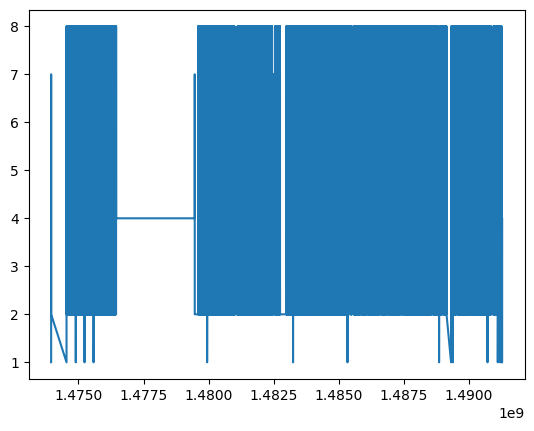

In [18]:
plt.plot(data_df['tunix'], data_df['obox_mode'])

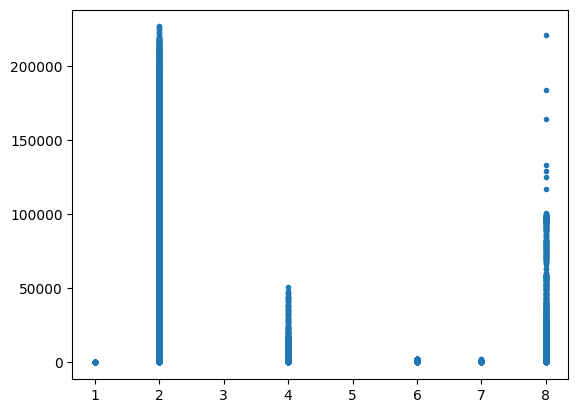

In [19]:
plt.plot(data_df['obox_mode'], data_df['sum_fe_rate'], '.')

**TODO**:
- Split train, test, validation
- Temporal structure
- FFT high pass filter
- Feature importance:
    - Permutation-importance after fitting the model
    - Effect of units of features: https://youtu.be/Y9nN_6sbXkM
- Interpretable ML in general:
    - https://www.youtube.com/playlist?list=PLpdmBGJ6ELUJaQDlOzg3tCoGc4ouyE55_
 
- Error propagation, confidence interval, errors over fitted parameters
- Kaggle
- Try simple models before using neural networks